<a href="https://colab.research.google.com/github/ShkarupyloMaksym/sigmoindus_IASA_Finals/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gdown
!pip install inference_sdk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.9/299.9 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.8 MB/s eta 0:00:00


In [ ]:
!sudo apt-get install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 32 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 2s (2,857 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

# Imports


In [ ]:
import os
import shutil
import pathlib
import zipfile
import numpy as np
import pandas as pd

from functools import partial

from matplotlib import pyplot as plt
import matplotlib.patches as patches

import seaborn as sns
import gdown
import random
from PIL import Image, ImageEnhance, ImageFilter, ImageDraw
import matplotlib.pyplot as plt
from tqdm import tqdm
import json

from inference_sdk import InferenceHTTPClient
import pytesseract


In [ ]:
!pip freeze > requirements.txt


# Some functions

## Data functions

In [ ]:
def download_data_from_gd(url, quiet=False):
  print('Data not exist, start downloading')
  gdown.download(url, data_zip_file_name, quiet=False)
  print('Downloaded')

# Some constants

In [ ]:
url = 'https://drive.google.com/uc?id=1Xo5MHYacC942SYPAtxLd15U5fNPW6tYb'
data_zip_file_name = 'data.zip'

In [ ]:
path_to_data_dir_abs = os.path.join('IASA_Champ_Final')

path_to_images_dir = os.path.join(path_to_data_dir_abs, 'app_data')
path_to_train_test_df = os.path.join(path_to_data_dir_abs, 'train_test_split.csv')
path_to_questions_df = os.path.join(path_to_data_dir_abs, 'ui_questions_train.tsv')

# Download, extract, import, show data

In [ ]:
if(os.path.exists(path_to_data_dir_abs)):
  print('Data have already extracted')
else:
  if(not os.path.exists(os.path.join(data_zip_file_name))):
    download_data_from_gd(url)
  print('Start extracting data')
  with zipfile.ZipFile(data_zip_file_name, 'r') as zipp:
      zipp.extractall()
  print('Data have just extracted')

Data not exist, start downloading


Downloading...
From (original): https://drive.google.com/uc?id=1Xo5MHYacC942SYPAtxLd15U5fNPW6tYb
From (redirected): https://drive.google.com/uc?id=1Xo5MHYacC942SYPAtxLd15U5fNPW6tYb&confirm=t&uuid=c3f22378-878d-496b-abd5-6682cef91ee8
To: /content/data.zip
100%|██████████| 218M/218M [00:02<00:00, 104MB/s]


Downloaded
Start extracting data
Data have just extracted


In [ ]:
class_names = [i for i in os.listdir(path_to_images_dir) if os.path.isdir(os.path.join(path_to_images_dir, i))]
class_names.sort()

In [ ]:
n = 10
print(f'{n} first classes:\n\n')
for i in range(n):
  print(f'{i+1}: {class_names[i]}')

10 first classes:


1: 24hourwallpaper
2: Almighty
3: AppStore
4: Bartender
5: Bettertouchtool
6: Bike
7: Books
8: Calendar
9: Canary Mail
10: Chrome


## Import data

## Import dataframes

In [ ]:
train_test_dataframe = pd.read_csv(path_to_train_test_df)
ui_questions_df = pd.read_csv(path_to_questions_df, sep='\t')

In [ ]:
replaces=[['Elelphas', 'Elephas'],['Marginnote', 'MarginNote'],['Merlin Project Express', 'Merlin Project'],['Mockuuups studio','Mockuuups Studio']]
for r in replaces:
  train_test_dataframe['screen_path'] = train_test_dataframe['screen_path'].map(lambda x: x.replace(r[0], r[1]))



In [ ]:
train_df = train_test_dataframe[train_test_dataframe['split'] == 'train']
test_df = train_test_dataframe[train_test_dataframe['split'] == 'test']

## Insides from dataframes

In [ ]:
train_test_dataframe.head()

,screen_path,split
0,24hourwallpaper/1707228345/,train
1,24hourwallpaper/1707228419/,train
2,24hourwallpaper/1707228389/,train
3,Almighty/1707228267/,train
4,Almighty/1707228277/,train


In [ ]:
ui_questions_df.head()

,App bundle,App name,Screen id,Question,Answer,Answer Type
0,com.jetson.24hourwallpaper-setapp,24hourwallpaper,1707228345,How many checkboxes are there on the screen?,3,number
1,com.jetson.24hourwallpaper-setapp,24hourwallpaper,1707228419,How many buttons are on the screen?,2,number
2,com.jetson.24hourwallpaper-setapp,24hourwallpaper,1707228419,Is the selected wallpaper Grand Canyon Mix?,Yes,yes/no
3,com.jetson.24hourwallpaper-setapp,24hourwallpaper,1707228419,How many dropdown menus are on the screen?,1,number
4,com.jetson.24hourwallpaper-setapp,24hourwallpaper,1707228389,"Is there a button ""Save"" on the screen?",No,yes/no


In [ ]:
ui_questions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   App bundle   846 non-null    object
 1   App name     846 non-null    object
 2   Screen id    846 non-null    int64 
 3   Question     846 non-null    object
 4   Answer       846 non-null    object
 5   Answer Type  846 non-null    object
dtypes: int64(1), object(5)
memory usage: 39.8+ KB


In [ ]:
ui_questions_df['Answer Type'].value_counts()

number         388
yes/no         250
string         115
coordinates     93
Name: Answer Type, dtype: int64

In [ ]:
types_unique=ui_questions_df['Answer Type'].unique()
sample_no=10
for t in types_unique:
  print(t, '\n')
  print(ui_questions_df[ui_questions_df['Answer Type']==t]['Question'].head(sample_no))
  print('\n')

number 

0          How many checkboxes are there on the screen?
1                   How many buttons are on the screen?
3            How many dropdown menus are on the screen?
5       How many images (wallpapers) are on the screen?
6           How many toolbar buttons are on the screen?
8                   How many wallpapers are in the app?
10    How many "+" buttons are there on the visible ...
14               How many toggle buttons are turned on?
15              How many toggle buttons are turned off?
17    On the visible screen, how many toggle buttons...
Name: Question, dtype: object


yes/no 

2           Is the selected wallpaper Grand Canyon Mix?
4               Is there a button "Save" on the screen?
7                   Does the application open at login?
9                     Is this a "Utility" menu section?
12                   Is this a "Settings" menu section?
13                Is this an "Automation" menu section?
16                      Is "Launch at login" turned on

In [ ]:
for q in ui_questions_df[ui_questions_df['Answer Type']=='coordinates']['Question']:
  if 'click' not in q:
    print(q)

Where is "Save" button located?
Where is the current selected element located?
How to switch to see newly added apps?
Where is the 'Export' button located on the screen?


## Import images

In [ ]:
dick = {'a':1, 'b':2}

print(list(dick))
print([i for i in dick])
print(list(dick.items()))

['a', 'b']
['a', 'b']
[('a', 1), ('b', 2)]


In [ ]:
def read_image(path):
    img_path = [i for i in os.listdir(path) if i.endswith('png')][0]
    img_path = os.path.join(path, img_path)

    # Open the PNG image using PIL
    png_image = Image.open(img_path)

    # Convert PNG image to JPEG format
    png_image_rgb = png_image.convert('RGB')

    return png_image_rgb, img_path


def read_json(path):
  json_path = [i for i in os.listdir(path) if i.endswith('json')]
  if json_path == []:
    return None
  json_path = os.path.join(path, json_path[0])
  json_file = None
  with open(json_path) as f:
    json_file = json.loads(f.read())
  return json_file


def image_get_generator(start_path, images_dataframe, column='screen_path', name_func = None):
  for i in images_dataframe['screen_path']:
    whole_path = os.path.join(start_path, i)
    path_splited = i.split('/')
    result = {'class': path_splited[0], 'id':path_splited[1], 'image': read_image(whole_path)[0], 'json': read_json(whole_path)}

    if name_func is not None:
      if isinstance(name_func, dict):
        name_func = list(name_func.items())

      if isinstance(name_func, list):
        for i, j in name_func:
          result[i] = j(whole_path)

    yield result


def get_images_paths(folder_path, images_dataframe):
  imgs = []
  for i in images_dataframe['screen_path']:
      whole_path = os.path.join(folder_path, i)
      path_splited = i.split('/')
      img_path = [i for i in os.listdir(whole_path) if i.endswith('png')][0]
      img_path = os.path.join(whole_path, img_path)
      imgs.append(img_path)
  return imgs


def only_json_get_generator(start_path, images_dataframe, column='screen_path'):
  for i in images_dataframe['screen_path']:
    path_splited = i.split('/')
    yield {'class': path_splited[0], 'id':path_splited[1], 'image': None, 'json': read_json(os.path.join(start_path, i))}

## Show image data

In [ ]:
imgs = image_get_generator(path_to_images_dir, train_df)

In [ ]:
example = imgs.__next__()

In [ ]:
print(example.keys())
for_print = ['class', 'id']
for i in for_print:
  print(f'{i} = {example[i]}')

plt.imshow(example['image'])
plt.show()

if example['json'] is not None:
  # Pretty print the JSON dictionary
  pretty_json = json.dumps(example['json'], indent=4, sort_keys=True)

  print(pretty_json)
else:
  print('JSON is None')

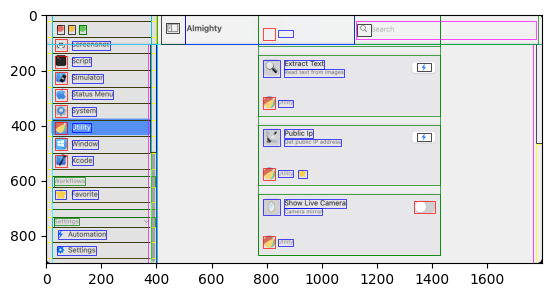

In [ ]:
def show_boxes_in_image(example):
  matplotlib_color_names = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']
  colors = {}
  def get_color_for_role(role):
    color = colors.get(role)
    if color is not None:
      return color
    new_color = len(colors)
    new_color %= len(matplotlib_color_names)
    new_color = matplotlib_color_names[new_color]
    colors[role] = new_color
    return new_color


  def add_rectangle_from_figure(ax, figure):
    boundbox = figure['bbox']
    rectangle = patches.Rectangle((boundbox[0], boundbox[1]), boundbox[2], boundbox[3], linewidth=0.5, edgecolor=get_color_for_role(figure['role']), facecolor='none')
    ax.add_patch(rectangle)


  def recursive_boundboxe_making(ax, figure, role=None):
    # Create a Rectangle patch
    if role is not None:
      if not isinstance(role, list):
        role = [role]
      if figure['role'] in role:
        add_rectangle_from_figure(ax, figure)
    else:
      add_rectangle_from_figure(ax, figure)

    for i in figure['children']:
      recursive_boundboxe_making(ax, i, role)

    # Add the Rectangle patch to the axis


  if example['json'] is not None:
    fig, ax = plt.subplots()
    plt.imshow(example['image'])
    figure = example['json']
    recursive_boundboxe_making(ax, figure, ['AXStaticText', 'AXButton', 'AXGroup'])
    plt.show()
  else:
    example_class, example_id = example['class'], example['id']
    print(f'{example_class}/{example_id} hasn`t json file')


show_boxes_in_image(example)

## Get statistic from JSONs

In [ ]:
json_stats = {}


def add_to_json_stats(role):
  if json_stats.get(role) is None:
    json_stats[role] = 1
    return
  json_stats[role] += 1


def recursive_add_to_json_stats(figure):
  add_to_json_stats(figure['role'])

  for i in figure['children']:
    recursive_add_to_json_stats(i)

In [ ]:
jsons = only_json_get_generator(path_to_images_dir, train_df)

for i in jsons:
  if i['json'] is not None:
    recursive_add_to_json_stats(i['json'])
print(len(json_stats))

json_stats = dict(sorted(json_stats.items(), key=lambda x:x[1], reverse=True))
uniques_class_names = list(json_stats.keys())


51


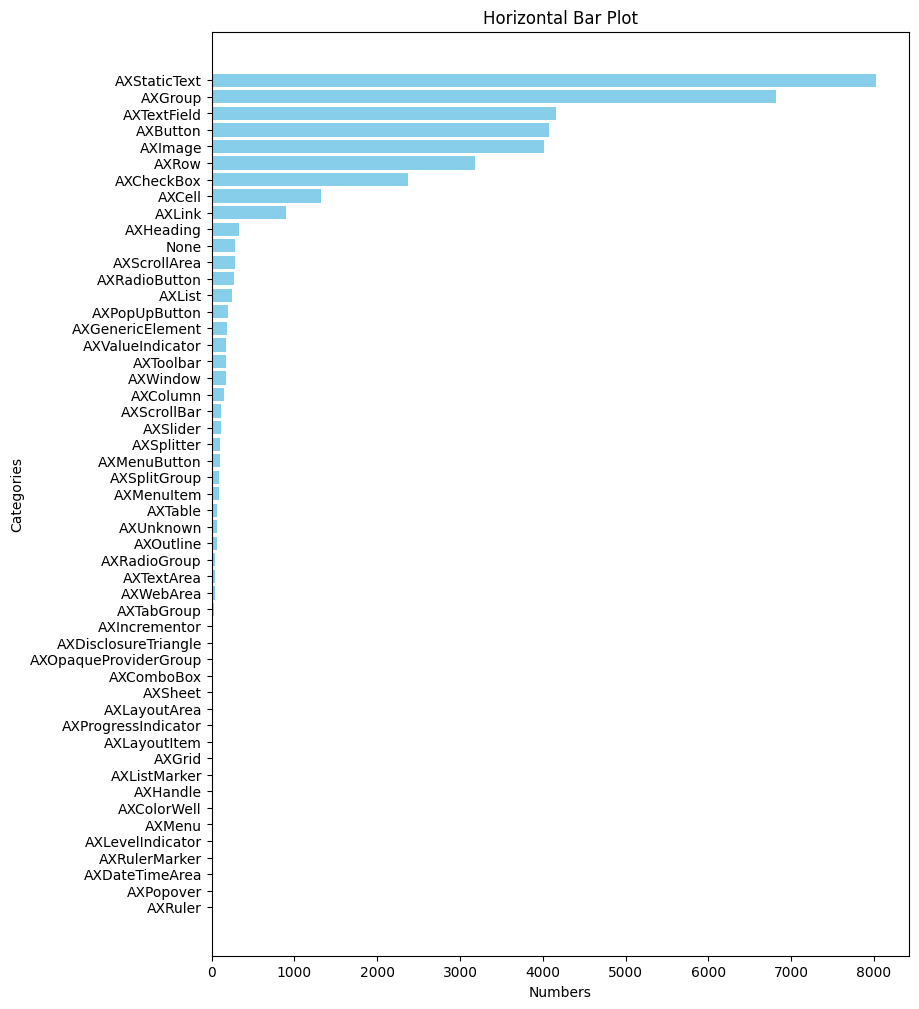

In [ ]:
plt.figure(figsize=(9, 12))
categories=list(json_stats.keys())
values=list(json_stats.values())
plt.barh(categories, values, color='skyblue')
plt.xlabel('Numbers')
plt.ylabel('Categories')
plt.title('Horizontal Bar Plot')
plt.gca().invert_yaxis()
plt.show()

# Model

## Constants

In [ ]:
CLIENT = InferenceHTTPClient(
    api_url="https://detect.roboflow.com",
    api_key="CMGC5tAVkgt7WWQ8bdZJ"
)

In [ ]:
role_descr = {'Label': 'text', 'Button': 'button', 'Image': 'image', 'Carousel': 'None', 'Check Box': 'toggle button', 'Link':'link', 'Pagination':'None',
'Paragraph':'None',
'Radio Button':'radio-button',
'Select':'None',
'Table':'table',
'Textarea':'textarea',
'Textbox':'text'}

## Functions

In [ ]:
def bbox_area(bbox):
    return (bbox['x2'] - bbox['x1']) * (bbox['y2'] - bbox['y1'])

def intersection_over_union(bbox1, bbox2):
    # Calculate intersection area
    x_left = max(bbox1['x1'], bbox2['x1'])
    y_top = max(bbox1['y1'], bbox2['y1'])
    x_right = min(bbox1['x2'], bbox2['x2'])
    y_bottom = min(bbox1['y2'], bbox2['y2'])

    intersection_area = max(0, x_right - x_left) * max(0, y_bottom - y_top)

    # Calculate union area
    union_area = bbox_area(bbox1) + bbox_area(bbox2) - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area

    return iou

def remove_overlapping(predictions, iou_threshold=0.6):
  for i, child1 in enumerate(predictions):
    for j, child2 in enumerate(predictions):
        if i != j:
          x1, y1, w1, h1 = child1['x'], child1['y'], child1['width'], child1['height']
          x2, y2, w2, h2 = child2['x'], child2['y'], child2['width'], child2['height']
          bbox1 = {'x1': x1-w1/2, 'x2':x1+w1/2, 'y1': y1-h1/2, 'y2': y1+h1/2}
          bbox2 = {'x1': x2-w2/2, 'x2':x2+w2/2, 'y1': y2-h2/2, 'y2': y2+h2/2}


          score = intersection_over_union(bbox1, bbox2)

          if score > iou_threshold:
            if child1['confidence'] > child2['confidence']:
              del predictions[j]
            else:
              del predictions[i]

def extract_text(image, bbox):
      x, y, w, h = bbox
      # Crop the image to the bounding box
      cropped_image = image.crop((x - w/2, y - h/2, x + w/2, y + h/2))

      # Use pytesseract to do OCR on the cropped image
      text = pytesseract.image_to_string(cropped_image, lang='eng')
      return text.strip()

In [ ]:
def get_image_prediction(image_path):
  result = CLIENT.infer(image_path, model_id="ui-element-detection-ohb3o/2")
  remove_overlapping(result['predictions'])
  image = Image.open(image_path)

  for pred in result['predictions']:
      x, y, w, h = pred['x'], pred['y'], pred['width'], pred['height']
      if pred['class'] == 'Label':
        pred['value'] = extract_text(image, (x, y, w, h))

      pred['role'] = pred['class']
      pred['children'] = 'None'
      pred['description'] = 'None'
      pred['bbox'] = [x, y, w, h]
      pred['visible_bbox'] = pred['bbox']
      pred['role_description'] = role_descr[pred['class']]
      keys = ['confidence', 'class_id', 'detection_id', 'class', 'x', 'y', 'width', 'height']
      for key in keys:
          pred.pop(key, None)

  return result['predictions']

def extract_image_info_into(imgs_paths, save_path_text='result_text', save_path_json='result_json', text_representation=False, json_representation=False):
  for image_path in imgs_paths:
    result = get_image_prediction(image_path)



    if json_representation:
      if not os.path.exists(save_path_json):
          os.makedirs(save_path_json)

      with open(f"{save_path_json}/{image_path.split('/')[-2]}_{image_path.split('/')[-1]}.json", 'w') as json_file:
          json.dump(result, json_file)

    if text_representation:
      if not os.path.exists(save_path_text):
            os.makedirs(save_path_text)
      elements = result

      descriptions = []
      role_counts = {}
      for element in elements:
          role = element['role']
          role_counts[role] = role_counts.get(role, 0) + 1
          role_description = element['role_description']
          bbox = element['bbox']
          vall = ''
          if element.get('value') is not None:
            vall = f" with text {element['value']}"
          description = f"{role_description.title()} with bounding box at x = {bbox[0]}, y = {bbox[1]}{vall}."
          descriptions.append(description)

      # Join all descriptions into a single plain text string
      plain_text = "\n".join(descriptions)
      for key, value in role_counts.items():
              plain_text += f"number of {key} is {value}\n"

      with open(f"{save_path_text}/{image_path.split('/')[-2]}_{image_path.split('/')[-1]}.txt", 'w') as file:
        file.write(plain_text)



## Prepare data

In [ ]:
imgs = get_images_paths(path_to_images_dir, train_df)
imgs_test = get_images_paths(path_to_images_dir, test_df)

## Model working

In [111]:
extract_image_info_into(imgs_test, save_path_text='path_final', json_representation=True, text_representation=True)

### Get text from images

In [ ]:
path_to_image = imgs[0]

result = get_image_prediction(path_to_image)

In [ ]:
bounding_boxes = []

for pred in result:
  if pred['role'] == 'Label':
    bounding_boxes.append(pred['bbox'])


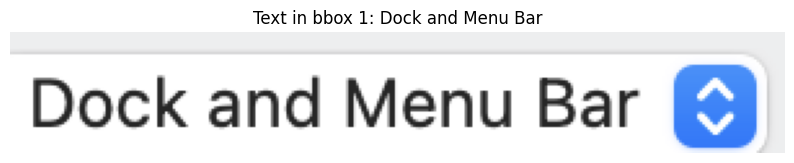

Text in bbox 1: Dock and Menu Bar


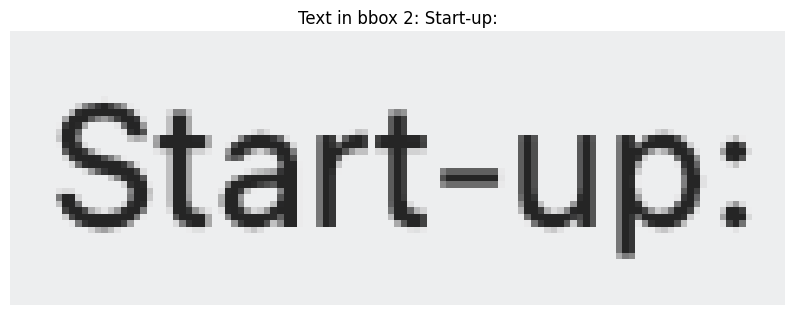

Text in bbox 2: Start-up:


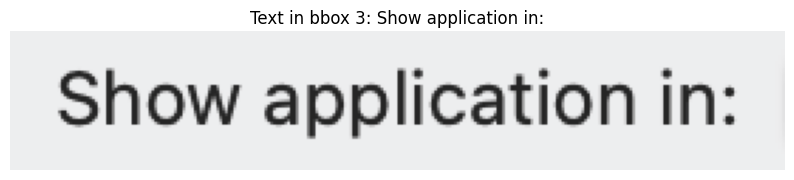

Text in bbox 3: Show application in:


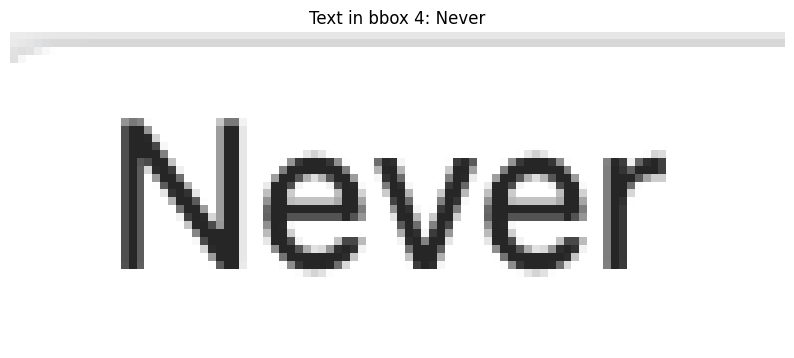

Text in bbox 4: Never


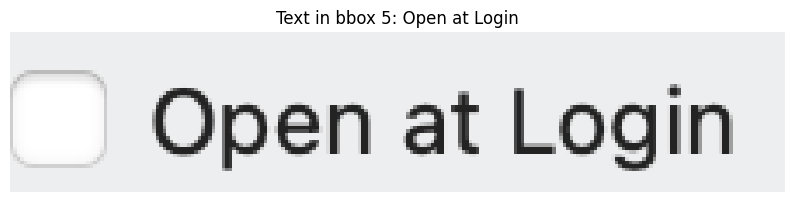

Text in bbox 5: Open at Login


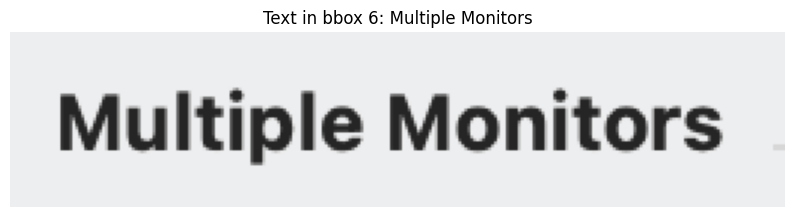

Text in bbox 6: Multiple Monitors


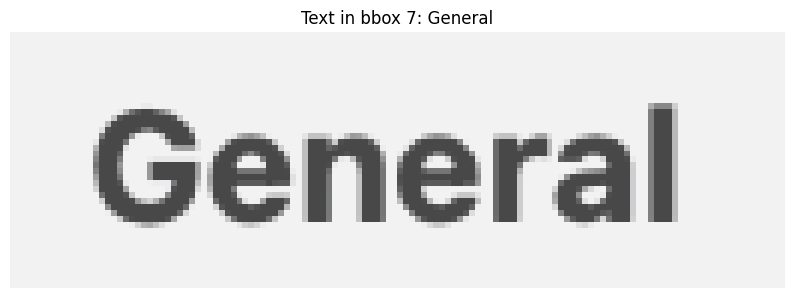

Text in bbox 7: General


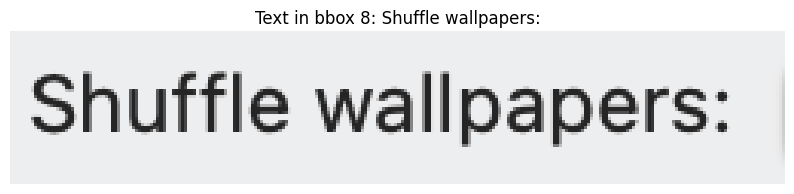

Text in bbox 8: Shuffle wallpapers:


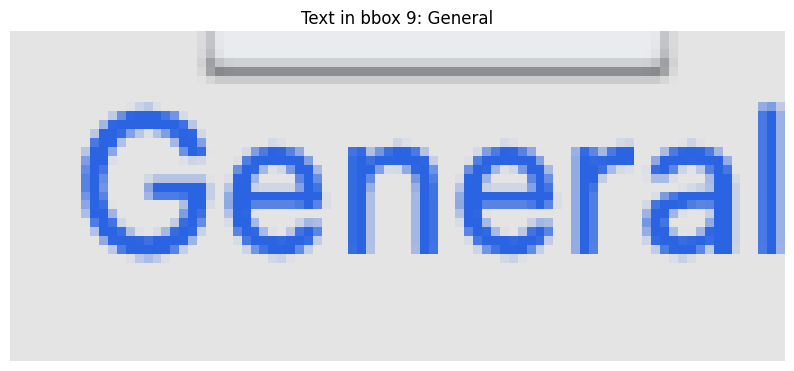

Text in bbox 9: General


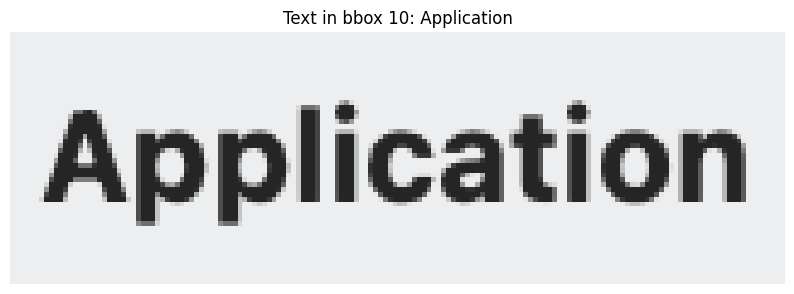

Text in bbox 10: Application


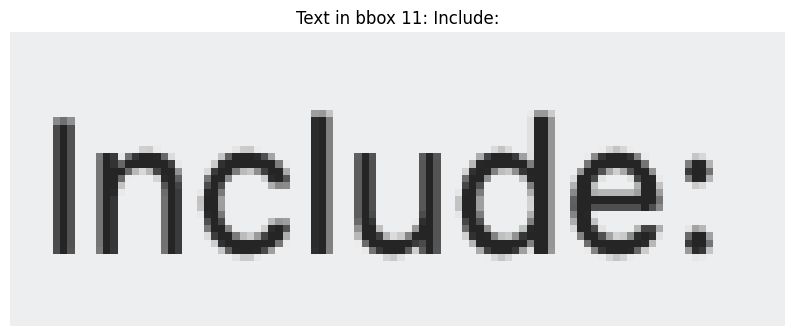

Text in bbox 11: Include:


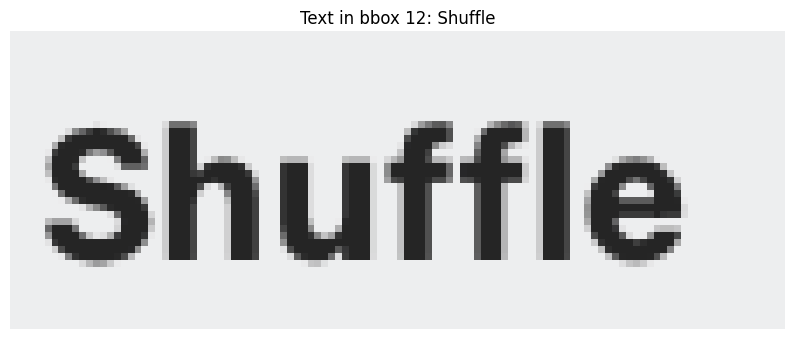

Text in bbox 12: Shuffle


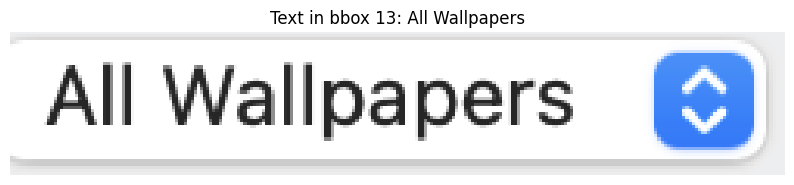

Text in bbox 13: All Wallpapers


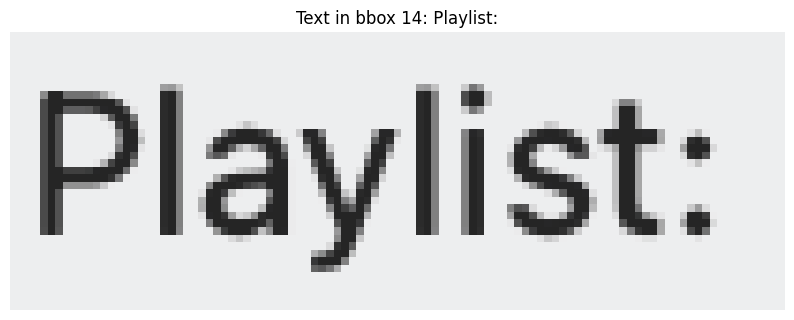

Text in bbox 14: Playlist:


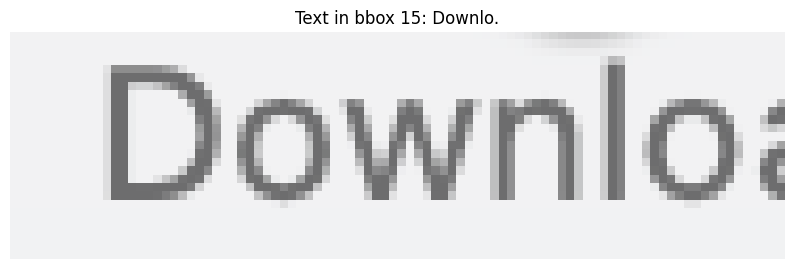

Text in bbox 15: Downlo.


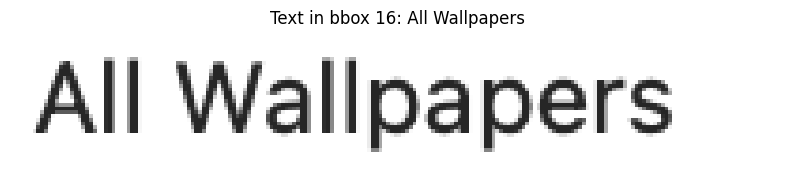

Text in bbox 16: All Wallpapers


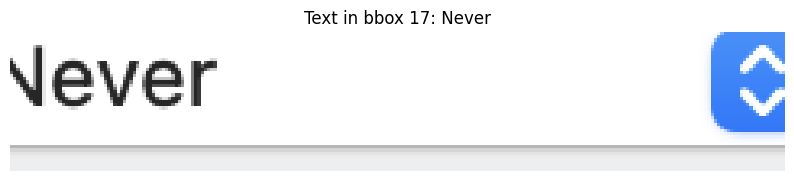

Text in bbox 17: Never


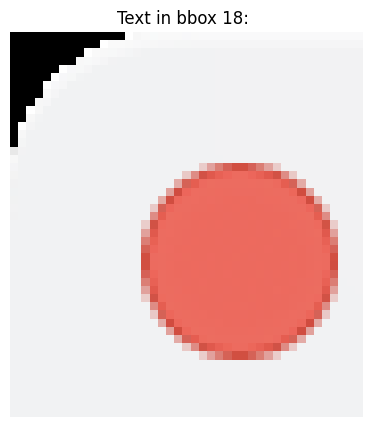

Text in bbox 18: 


In [ ]:
def extract_and_plot_text(image, bbox, index):
    x, y, w, h = bbox
    cropped_image = image.crop((x - w / 2, y - h / 2, x + w / 2, y + h / 2))


    # Use pytesseract to do OCR on the cropped image
    text = pytesseract.image_to_string(cropped_image, lang='eng').strip()

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.imshow(cropped_image)
    plt.title(f'Text in bbox {index}: {text}')
    plt.axis('off')  # Hide axis
    plt.show()

    return text

# Iterate over the bounding boxes, extract text, and plot
image = Image.open(path_to_image).convert("RGB")

for i, bbox in enumerate(bounding_boxes, start=1):
    text = extract_and_plot_text(image, bbox, i)
    print(f"Text in bbox {i}: {text}")


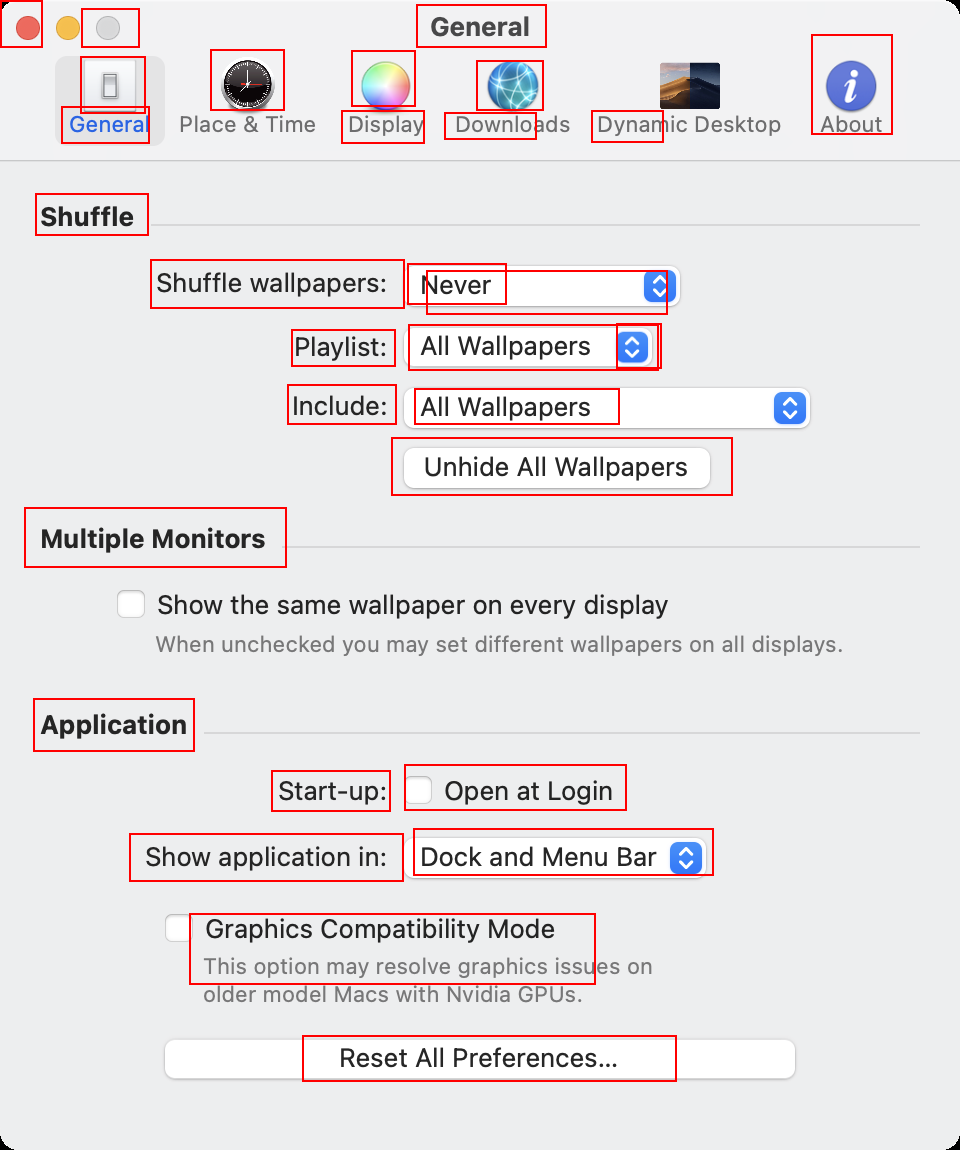

In [ ]:
def draw_elements(children, image):

    for child in children:
      x, y, w, h = child['bbox']
      image.rectangle([(x - w / 2, y - h / 2), (x + w / 2, y + h / 2)], outline="red", width=2)

    return image

img_draw = ImageDraw.Draw(image)


# Draw all elements
img_draw = draw_elements(result, img_draw)

image


## Zip and download

In [ ]:
!zip -r my_folder.zip {'path_final'}